## **Modelo de Clasificación Textos - Productos de tiendas**

Gerson Gabriel Erira Sánchez

Jhon Esteban Arredondo Parra

---






Según la publicación tituladad "Clasificación automatica de textos usando redes de palabras", la clasificación automática puede definirse como la acción ejecutada por un sistema artificial sobre un conjunto de elementos para ordenarlos en clases o categorías. La clasificación automática de textos ha cobrado mayor importancia en los últimos años debido, en parte, a los grandes volúmenes de textos digitales que se almacenan en bases de datos empresariales. (https://scielo.conicyt.cl/pdf/signos/v47n86/a01.pdf)

El presente trabajo tiene como objetivo seleccionar y entrenar un modelo de clasificación de textos para productos de consumo masivo; esta agregación de productos por categoria es relavante para el proximo trabajo de regresión, donde se tiene una base de datos de ventas de productos en 4 departamentos y un gran numero de productos.

### 1. Instalaciones

In [1]:
!pip install openpyxl
!pip install imbalanced-learn
!pip install nltk
import nltk # Import the nltk module
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### 1.1 Librerias

In [2]:
# Cargar datos de Github
#===============================================================================
import io
import requests
from io import BytesIO

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

from pandas import DataFrame
import joblib


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#import sklearn.externals

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')




### 2. Carga de datos

La base de datos se obtuvo de la plataforma Kaggle (https://www.kaggle.com/datasets/camiloemartinez/productos-consumo-masivo/data), la cual tiene un total de 25.638 registros de productos disponibles en los dos supermercados mas grandes de Colombia en 2019

In [3]:
response = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/Productos%20Consumo%20Masivo.xlsx')
response.raise_for_status()

# Guardar información del archivo en Dataframe
df = pd.read_excel(io.BytesIO(response.content))


In [4]:
df.head()

,date,prod_id,prod_name,prod_name_long,prod_brand,category,subcategory,tags,prod_unit_price,prod_units,prod_icon,prod_source,source_type
0,20190609,7702155021451,Limpia tapicería en espuma Binner,Limpia tapicería en espuma Binner x 400ml,BINNER,Supermercado,Aseo de hogar,Alfombras,15590,Unidades,../icons/SVG/53-places/home-3.svg,VERDE,1
1,20190609,7702155016457,Limpia tapicería y alfombras Binner,Limpia tapicería y alfombras Binner x 500ml,BINNER,Supermercado,Aseo de hogar,Alfombras,13993,Unidades,../icons/SVG/53-places/home-3.svg,VERDE,1
2,20190609,4008455446318,Limpiador Dr. Beckmann alfombras 2en1 poder oxi,Limpiador Dr. Beckmann alfombras 2en1 poder ox...,DR.BECKMANN,Supermercado,Aseo de hogar,Alfombras,16513,Unidades,../icons/SVG/53-places/home-3.svg,VERDE,1
3,20190609,7702532312677,Aceite Bon Aire eléctrico perfume flores,Aceite Bon Aire eléctrico perfume flores x 25 ml,BONAIRE,Supermercado,Aseo de hogar,Ambientadores,14990,Unidades,../icons/SVG/58-beauty-spas/spa-vapor.svg,VERDE,1
4,20190609,7702532312967,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,BONAIRE,Supermercado,Aseo de hogar,Ambientadores,34990,Unidades,../icons/SVG/58-beauty-spas/spa-vapor.svg,VERDE,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25638 entries, 0 to 25637
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             25638 non-null  int64 
 1   prod_id          25638 non-null  int64 
 2   prod_name        25506 non-null  object
 3   prod_name_long   25638 non-null  object
 4   prod_brand       25586 non-null  object
 5   category         25638 non-null  object
 6   subcategory      25638 non-null  object
 7   tags             25638 non-null  object
 8   prod_unit_price  25633 non-null  object
 9   prod_units       25231 non-null  object
 10  prod_icon        25231 non-null  object
 11  prod_source      25638 non-null  object
 12  source_type      25638 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 2.5+ MB


Teniendo en cuenta lo anterior y visualizando la información del Dataset, nos damos cuenta que tenemos variables que no aportarían al modelo de predicción de subcategoria por producto, por tanto se procede a eliminar las columnas innecesarias.

### 3. Preparación de datos

In [6]:
#Borrando columnas innecesarias
df.drop(['date', 'prod_id', 'prod_name', 'prod_brand',
       'category', 'prod_unit_price', 'prod_units',
       'prod_icon', 'prod_source', 'source_type', 'tags'], axis='columns', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25638 entries, 0 to 25637
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   prod_name_long  25638 non-null  object
 1   subcategory     25638 non-null  object
dtypes: object(2)
memory usage: 400.7+ KB


In [8]:
df.head()

,prod_name_long,subcategory
0,Limpia tapicería en espuma Binner x 400ml,Aseo de hogar
1,Limpia tapicería y alfombras Binner x 500ml,Aseo de hogar
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...,Aseo de hogar
3,Aceite Bon Aire eléctrico perfume flores x 25 ml,Aseo de hogar
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,Aseo de hogar


Dado que algunos nombres de productos tienen tildes, se procede a eliminar todas las tildes que estén los nombres de productos

In [9]:
##Eliminar tildes
df['ProdTags'] = df['prod_name_long'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.head()

,prod_name_long,subcategory,ProdTags
0,Limpia tapicería en espuma Binner x 400ml,Aseo de hogar,Limpia tapiceria en espuma Binner x 400ml
1,Limpia tapicería y alfombras Binner x 500ml,Aseo de hogar,Limpia tapiceria y alfombras Binner x 500ml
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...,Aseo de hogar,Limpiador Dr. Beckmann alfombras 2en1 poder ox...
3,Aceite Bon Aire eléctrico perfume flores x 25 ml,Aseo de hogar,Aceite Bon Aire electrico perfume flores x 25 ml
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,Aseo de hogar,Ambientador Aire Varitas Bambu Bonaire 2 Repue...


Ahora el Dataset se compone de dos variables, de las cuales la variable "ProdTags" es la que se debe clasificar según el tipo de producto.

In [10]:
df.drop(['prod_name_long'], axis='columns', inplace=True)
df.head()

,subcategory,ProdTags
0,Aseo de hogar,Limpia tapiceria en espuma Binner x 400ml
1,Aseo de hogar,Limpia tapiceria y alfombras Binner x 500ml
2,Aseo de hogar,Limpiador Dr. Beckmann alfombras 2en1 poder ox...
3,Aseo de hogar,Aceite Bon Aire electrico perfume flores x 25 ml
4,Aseo de hogar,Ambientador Aire Varitas Bambu Bonaire 2 Repue...


In [11]:
df['subcategory'].unique()

array(['Aseo de hogar', 'Bebidas', 'Belleza', 'Charcutería',
       'Cuidado de ropa y calzado', 'Cuidado Personal', 'Despensa',
       'Dulces y postres', 'Lácteos, huevos y refrigerados',
       'Limpieza de cocina', 'Panadería y Pastelería', 'Pasabocas',
       'Productos Congelados', 'Vinos y Licores'], dtype=object)

Podemos identificar que la base de datos original con la que entrenarémos el modelo de clasificación contiene 15 Subcategorias, con esto identificamos la necesidad de agregar dos nuevas categorias ("Utiles Escolares" y "Frutas y Verdudas"), lo anterior dado que la base de datos de compras (Base de datos con la que harémos prediccones de ventas) contiene productos que se deben clasificar en estas nuevas categorias; la base de datos complementaria que se cargará a continuación fue recolectada de diferentes paginas que comercializan "Utiles Escolares" y "Frutas y Verduras"



Agregar base de datos complementaria con nuevas categorias de "Utiles Escolares" y "Frutas y Verduras"

In [12]:
response2 = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/Nuevas_Categorias_Clasificacion.xlsx')
response2.raise_for_status()

# Guardar información del archivo en Dataframe
df_complemento = pd.read_excel(io.BytesIO(response2.content))

In [13]:
df_complemento.head()

,subcategory,ProdTags
0,Frutas y Verduras,ACACIA INDIA NATURAL LIGH 15 gr
1,Frutas y Verduras,Acelga 500 gr
2,Frutas y Verduras,Acelga Kosher TAEQ 500 gr
3,Frutas y Verduras,AGRAZ 250 gr
4,Frutas y Verduras,AGRAZ CONGELADO FRUTINAL 200 gr


In [14]:
#Numero de Registros en Base de Datos Original
len(df)

25638

In [15]:
#Agregar df_complemtento en df
df = pd.concat([df, df_complemento], ignore_index=True)

In [16]:
#Base de datos con nuevas categorias agregadas
df.shape

(27469, 2)

In [17]:
#eliminar tildes
df['ProdTags'] = df['ProdTags'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.head()

,subcategory,ProdTags
0,Aseo de hogar,Limpia tapiceria en espuma Binner x 400ml
1,Aseo de hogar,Limpia tapiceria y alfombras Binner x 500ml
2,Aseo de hogar,Limpiador Dr. Beckmann alfombras 2en1 poder ox...
3,Aseo de hogar,Aceite Bon Aire electrico perfume flores x 25 ml
4,Aseo de hogar,Ambientador Aire Varitas Bambu Bonaire 2 Repue...


In [18]:
# Agrupar por subcategory y ProdTags, contar combinaciones
conteo = df.groupby(['subcategory', 'ProdTags']).size().reset_index(name='count')

In [19]:
conteo.head()

,subcategory,ProdTags,count
0,Aseo de hogar,Aceite Bon Aire electrico perfume flores x 25 ml,4
1,Aseo de hogar,Acido Magistral limpia desmancha x 2000 ml,4
2,Aseo de hogar,Acido Magistral limpia desmancha x 800ml,4
3,Aseo de hogar,Aerosol Clorox Desinfectante Fresco x 232ml,4
4,Aseo de hogar,Aerosol Crisp Linen X 370 gr,1


In [20]:
#Numro de registros duplicados
sum(conteo[conteo['count']>1]['count'])

24839

In [21]:
#Numero de registros unicos
sum(conteo[conteo['count']==1]['count'])

2630

In [22]:
#Total Registros Base de datos
conteo['count'].sum()

np.int64(27469)

In [23]:
#Numero de Productos unicos
len(conteo)

9732

####**Registros Unicos y Duplicados**

Revisaremos a detalle como se distribuyen los registros entre Referencias unicas y duplicadas.
- Identificar porcentaje de productos unicos y duplicados (revisa que porcentaje de productos tienen registros duplicados y cuales son registros unicos)
- Identificar porcentaje de registros unicos y duplicados (revisa el numero de registros que están duplicados en la base de datos)

In [24]:
##Productos unicos y duplicados

def calcular_porcentajes(grupo):
    total = len(grupo)
    duplicados = (grupo['count'] > 1).sum()
    unicos = (grupo['count'] == 1).sum()
    return pd.Series({
        'duplicados':duplicados,
        'unicos':unicos,
        'total':total,
        'porc_duplicados': duplicados / total * 100,
        'porc_unicos': unicos / total * 100
    })


porcentajes = conteo.groupby('subcategory').apply(calcular_porcentajes).sort_values(by='subcategory', ascending=True).reset_index()

print(porcentajes)


                       subcategory  duplicados  unicos   total  \
0                    Aseo de hogar       407.0    46.0   453.0   
1                          Bebidas       342.0    92.0   434.0   
2                          Belleza       550.0   128.0   678.0   
3                      Charcutería       196.0     7.0   203.0   
4                 Cuidado Personal       722.0    57.0   779.0   
5        Cuidado de ropa y calzado       237.0    49.0   286.0   
6                         Despensa       790.0   198.0   988.0   
7                 Dulces y postres       469.0    84.0   553.0   
8                Frutas y Verduras        41.0   972.0  1013.0   
9               Limpieza de cocina       361.0    32.0   393.0   
10  Lácteos, huevos y refrigerados       844.0    41.0   885.0   
11          Panadería y Pastelería       398.0     3.0   401.0   
12                       Pasabocas       637.0    84.0   721.0   
13            Productos Congelados       249.0     4.0   253.0   
14        

**Numero de Registos duplicados y unicos por subcategoria**

In [25]:
# Numero de Registros duplicados y unicos por categoria
def calcular_porcentajes(grupo):
    total = grupo['count'].sum()
    duplicados = sum(grupo[grupo['count']>1]['count'])
    unicos = sum(grupo[grupo['count']==1]['count'])
    return pd.Series({
        'duplicados':duplicados,
        'unicos':unicos,
        'total':total,
        'porc_duplicados': duplicados / total * 100,
        'porc_unicos': unicos / total * 100
    })


porcentajes2 = conteo.groupby('subcategory').apply(calcular_porcentajes).sort_values(by='subcategory', ascending=True).reset_index()

print(porcentajes2)

                       subcategory  duplicados  unicos   total  \
0                    Aseo de hogar      1467.0    46.0  1513.0   
1                          Bebidas      1225.0    92.0  1317.0   
2                          Belleza      1835.0   128.0  1963.0   
3                      Charcutería       622.0     7.0   629.0   
4                 Cuidado Personal      2501.0    57.0  2558.0   
5        Cuidado de ropa y calzado       846.0    49.0   895.0   
6                         Despensa      2902.0   198.0  3100.0   
7                 Dulces y postres      1680.0    84.0  1764.0   
8                Frutas y Verduras        85.0   972.0  1057.0   
9               Limpieza de cocina      1542.0    32.0  1574.0   
10  Lácteos, huevos y refrigerados      3132.0    41.0  3173.0   
11          Panadería y Pastelería      1466.0     3.0  1469.0   
12                       Pasabocas      1820.0    84.0  1904.0   
13            Productos Congelados       762.0     4.0   766.0   
14        

Teniendo en cuenta lo anterior podemos observar que en general los registros de productos duplicados por categoria tienen un porcentaje superior al 93%, ademas se evidencia que solo dos categorias tienen un 8% de registros duplicados (categorias agregadas de "Utiles Escolares" y "Frutas y Verduras" - construcción propia)

### 4.  Descripción de categorías

Se procede a explorar el dataset, se comienza revisando como están distribuidos los registros por subcategoria

In [26]:
df.groupby('subcategory').ProdTags.count().sort_values(ascending=False)

,ProdTags
subcategory,
"Lácteos, huevos y refrigerados",3173
Despensa,3100
Vinos y Licores,3013
Cuidado Personal,2558
Belleza,1963
Pasabocas,1904
Dulces y postres,1764
Limpieza de cocina,1574
Aseo de hogar,1513


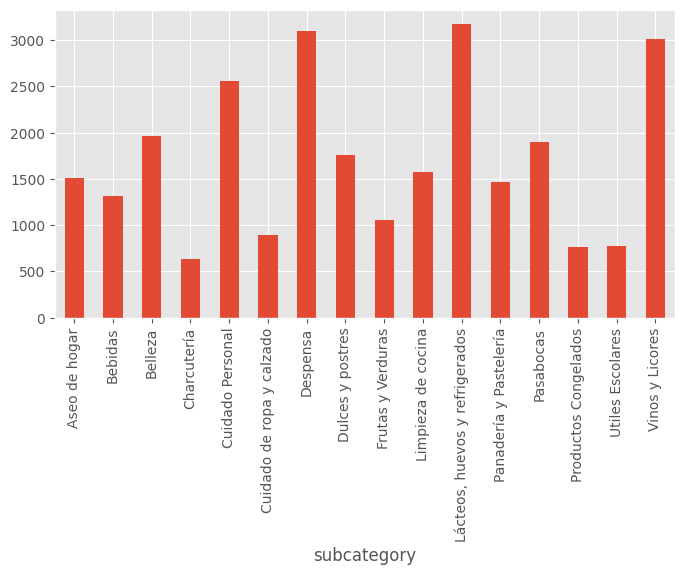

In [27]:
fig = plt.figure(figsize=(8,4))
df.groupby('subcategory').ProdTags.count().plot.bar(ylim=0)
plt.show()

Teniendo en cuenta la grafica anterior nos damos cuenta que las categorias están desbalanceadas, por tanto se procede a balancear el dataset con ayuda de RandomUnderSampler.

### 5. Balanceo de subcategorias

Es importante tener un dataset balanceado para que el modelo no de mas peso a la subcategoria que tiene mas registros

In [28]:


# Inicializar el RandomUnderSampler
rus = RandomUnderSampler(random_state=123) #semilla de 123

# Separar las subcategorias y el nombre de producto
X = df.drop('subcategory', axis=1)  # Nombre producto
y = df['subcategory']  # Subcategoria

# Ajustar y transformar los datos
X_res, y_res = rus.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['subcategory'] = y_res

# Mostrar la nueva distribución de clases
df_resampled['subcategory'].value_counts()

,count
subcategory,
Aseo de hogar,629
Bebidas,629
Belleza,629
Charcutería,629
Cuidado Personal,629
Cuidado de ropa y calzado,629
Despensa,629
Dulces y postres,629
Frutas y Verduras,629


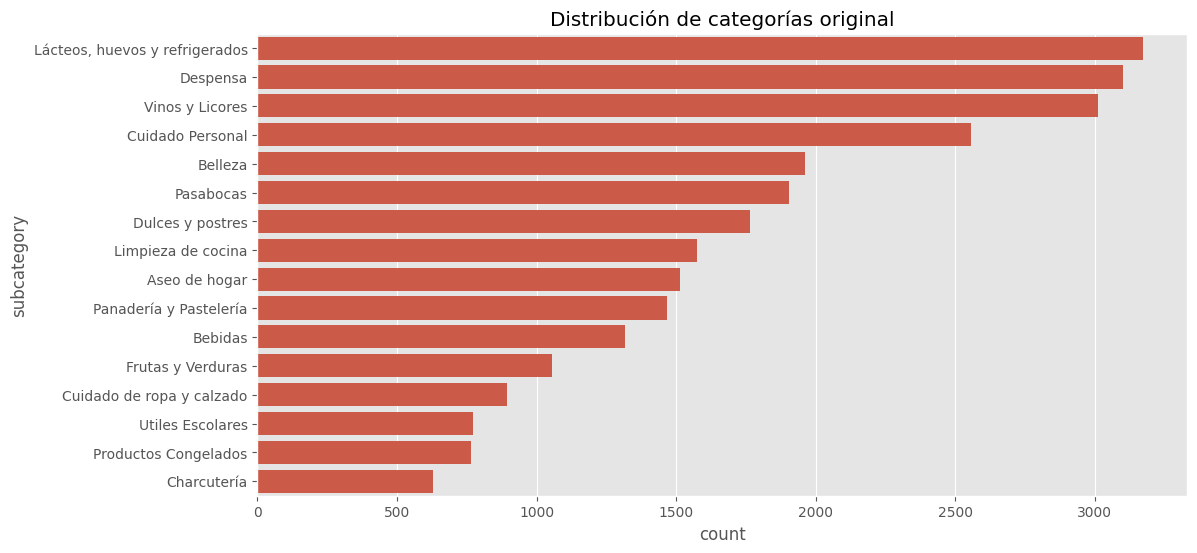

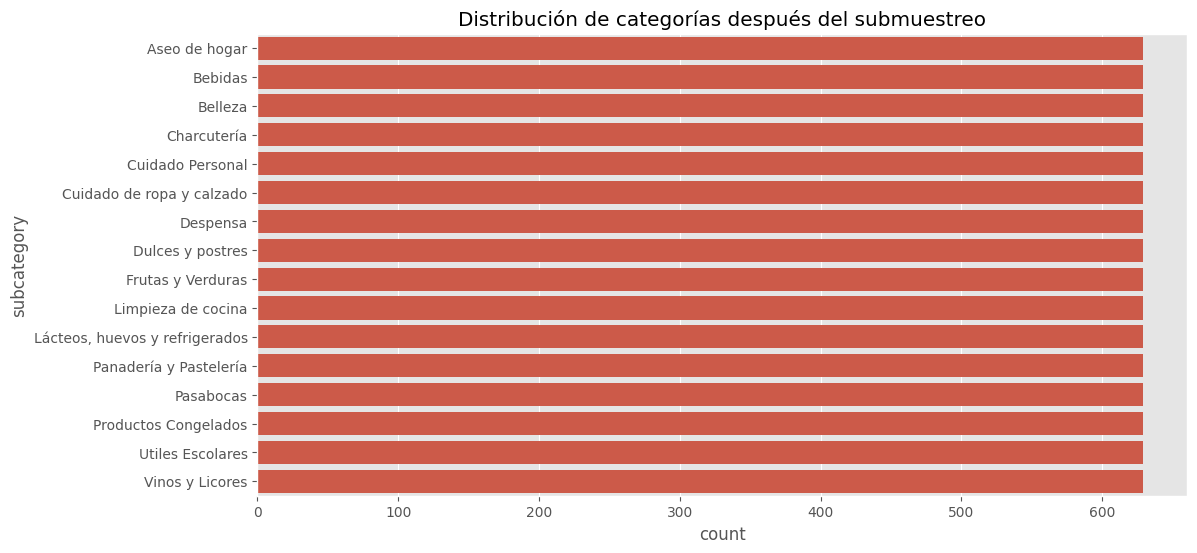

In [29]:
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de clases originales
plt.figure(figsize=(12, 6))
sns.countplot(y='subcategory', data=df, order=df['subcategory'].value_counts().index)
plt.title('Distribución de categorías original')
plt.show()

# Gráfico de clases después del submuestreo
plt.figure(figsize=(12, 6))
sns.countplot(y='subcategory', data=df_resampled, order=df_resampled['subcategory'].value_counts().index)
plt.title('Distribución de categorías después del submuestreo')
plt.show()

In [30]:
df=df_resampled

In [31]:
df.shape

(10064, 2)

In [32]:
#Identificamos la variación de registros unicos y duplicados
conteo_shape=df.groupby(['subcategory','ProdTags']).size().reset_index(name='count')

unicos2=conteo_shape[conteo_shape['count']==1]
duplicados2=conteo_shape[conteo_shape['count']>1]

In [33]:
porcentajes_shape=conteo_shape.groupby('subcategory').apply(calcular_porcentajes).sort_values(by='subcategory', ascending=True).reset_index()

**Identificaremos cual es la distribución entre registros de productos unicos y duplicados de la base de datos balanceada a comparación con la original**

In [34]:
#Base de datos Balanceada
porcentajes_shape

,subcategory,duplicados,unicos,total,porc_duplicados,porc_unicos
0,Aseo de hogar,456.0,173.0,629.0,72.496025,27.503975
1,Bebidas,485.0,144.0,629.0,77.106518,22.893482
2,Belleza,377.0,252.0,629.0,59.936407,40.063593
3,Charcutería,622.0,7.0,629.0,98.887122,1.112878
4,Cuidado Personal,313.0,316.0,629.0,49.761526,50.238474
5,Cuidado de ropa y calzado,555.0,74.0,629.0,88.235294,11.764706
6,Despensa,289.0,340.0,629.0,45.945946,54.054054
7,Dulces y postres,404.0,225.0,629.0,64.228935,35.771065
8,Frutas y Verduras,21.0,608.0,629.0,3.338633,96.661367
9,Limpieza de cocina,501.0,128.0,629.0,79.650238,20.349762


In [35]:
#Base de datos Original
porcentajes2

,subcategory,duplicados,unicos,total,porc_duplicados,porc_unicos
0,Aseo de hogar,1467.0,46.0,1513.0,96.959683,3.040317
1,Bebidas,1225.0,92.0,1317.0,93.014427,6.985573
2,Belleza,1835.0,128.0,1963.0,93.479368,6.520632
3,Charcutería,622.0,7.0,629.0,98.887122,1.112878
4,Cuidado Personal,2501.0,57.0,2558.0,97.771697,2.228303
5,Cuidado de ropa y calzado,846.0,49.0,895.0,94.525140,5.474860
6,Despensa,2902.0,198.0,3100.0,93.612903,6.387097
7,Dulces y postres,1680.0,84.0,1764.0,95.238095,4.761905
8,Frutas y Verduras,85.0,972.0,1057.0,8.041627,91.958373
9,Limpieza de cocina,1542.0,32.0,1574.0,97.966963,2.033037


En las anteriores tablas se puede observar que el porcentaje de registros unicos por subcategoria incrementó a comparación con la base de datos original, lo anterior fue resultado de la eliminación de registros con el metodo de balanceo RandomUnderSampler

In [36]:
df

,ProdTags,subcategory
14817,Desinfectante Mr Musculo glade paraiso azul x ...,Aseo de hogar
14749,Repuesto Glade limon aceite natural x 3 unds x...,Aseo de hogar
20289,Blanqueador Clorox total magia floral x 2000ml...,Aseo de hogar
31,Ambientador Spray Frescura Ambiental Canela Bo...,Aseo de hogar
20315,Desinfectante de frutas y vegetales kilol x 1000g,Aseo de hogar
...,...,...
25461,Vino rosado Santa Helena x 750 ml pague 2 lle...,Vinos y Licores
25463,Vino Saint Louis beaujulais x 750 ml,Vinos y Licores
6417,Vino Santa Carolina reservado sauvignon blanco...,Vinos y Licores
6551,Cava Freixenet Cordon Negro x 750 ml - Vino es...,Vinos y Licores


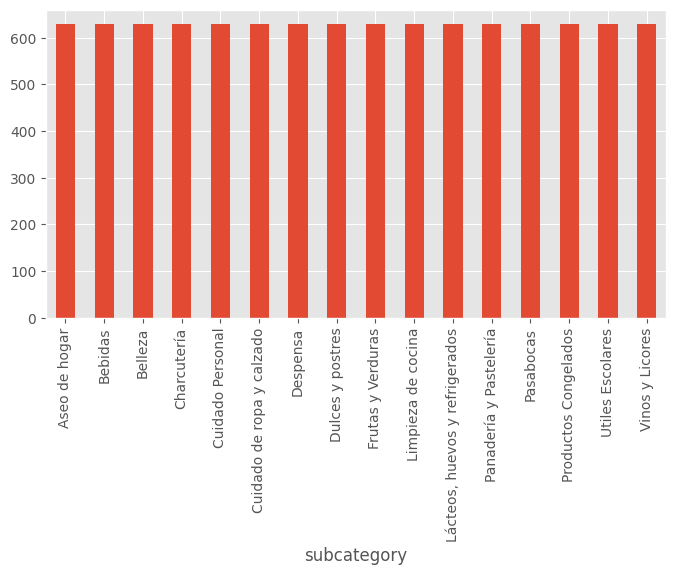

In [37]:
fig = plt.figure(figsize=(8,4))
df.groupby('subcategory').ProdTags.count().plot.bar(ylim=0)
plt.show()

Teniendo en cuenta la tabla y grafico anterior podemos observar que todas las categorias de la base de datos está balanceada.

### 6.  Preprocesamiento de texto y creación de bolsa de palabras

In [38]:
#Stopwords

spanish_stopwords = stopwords.words('spanish') + list(punctuation)+list(range(10,2000,10))


#stemming
stemmer = SnowballStemmer('spanish')

In [39]:
#Creacion de bolsa de palabras

vectorizer = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frecuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df=5              #los terminos deben aparecer en almenos 5 productos
                             , encoding='latin-1'
                             , ngram_range=(1, 3)
                             , stop_words=spanish_stopwords
                       )
features = vectorizer.fit_transform(df.ProdTags)
labels = df['subcategory']
features.shape

(10064, 4538)

In [40]:
terms = vectorizer.get_feature_names_out()

doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features)]
dv = pd.DataFrame(data=features.toarray(), index=doc_names, columns=terms)
dv.head()

,10,10 lleve,10 lleve 12,10 ml,10 und,10 unds,100,100 gr,100 hojas,100 hojas cosido,...,zeux aluminio esterilizado,ziploc,zipper,zipper colores,zipper colores mediana,zorba,zorba griego,zuccardi,zulia,zumo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df=df.reset_index()
dv=dv.reset_index()

In [42]:
# Dataset con bolsa de palabras
result = pd.merge(df[['subcategory']], dv, left_index=True, right_index=True, how="inner")
result.drop(['index'], axis='columns', inplace=True)

result[1:40]

,subcategory,10,10 lleve,10 lleve 12,10 ml,10 und,10 unds,100,100 gr,100 hojas,...,zeux aluminio esterilizado,ziploc,zipper,zipper colores,zipper colores mediana,zorba,zorba griego,zuccardi,zulia,zumo
1,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Aseo de hogar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7. Identificación de modelos

In [60]:
#Identificación de los mejores modelos:

models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
]

#Cross-validation: 10-folds
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [61]:
cv_df[:][0:60]

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.948361
1,RandomForestClassifier,1,0.952334
2,RandomForestClassifier,2,0.955313
3,RandomForestClassifier,3,0.926514
4,RandomForestClassifier,4,0.935388
5,RandomForestClassifier,5,0.953280
6,RandomForestClassifier,6,0.952286
7,RandomForestClassifier,7,0.953280
8,RandomForestClassifier,8,0.941352
9,RandomForestClassifier,9,0.940358


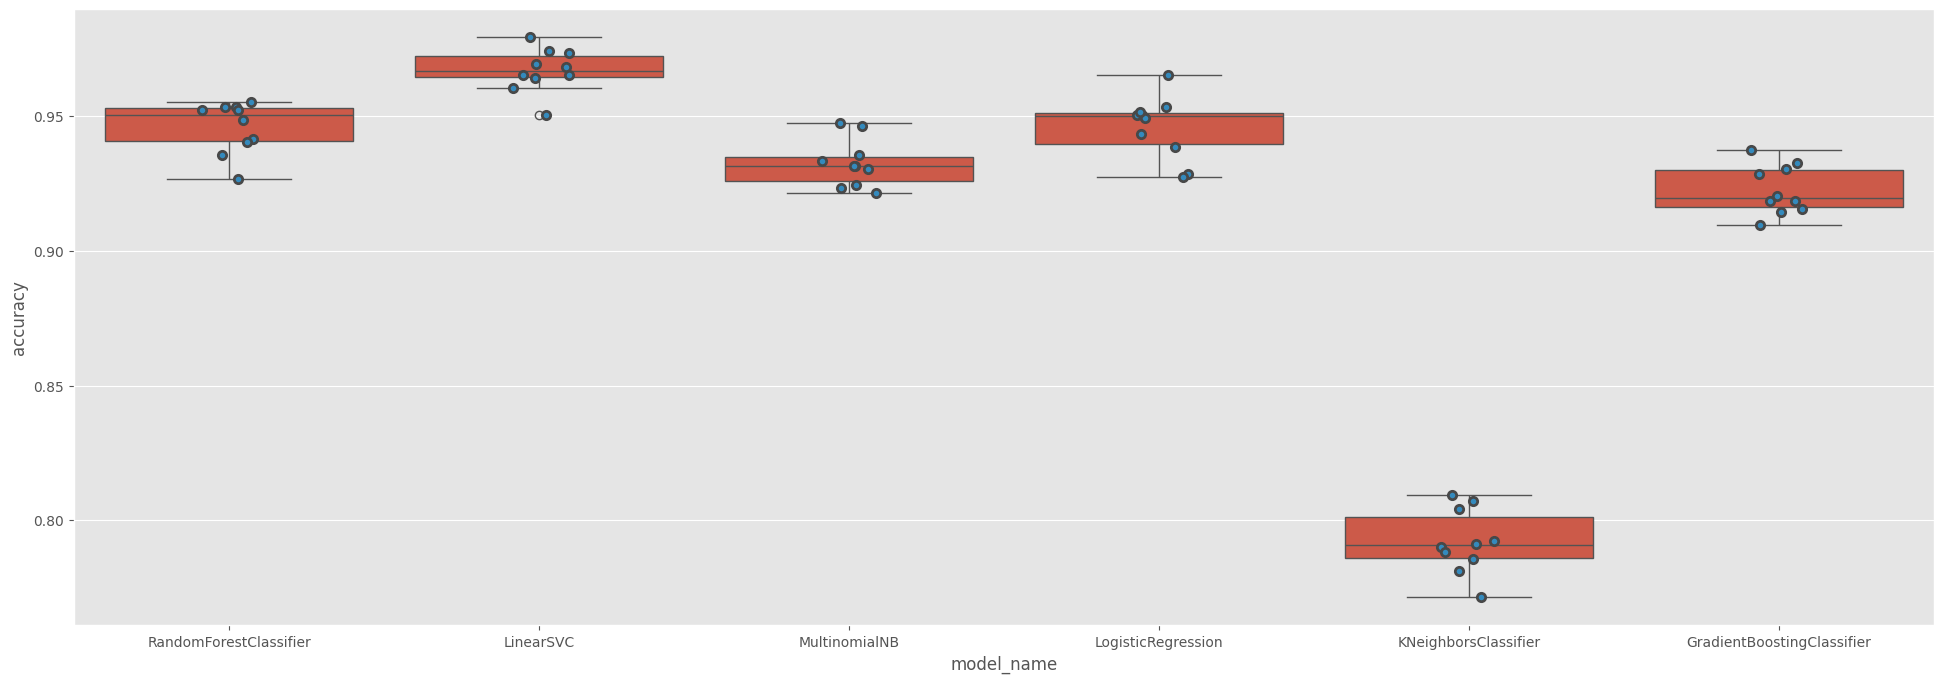

In [62]:
# Gráfica de accuracy de los modelos

figsize=(24,8)

plt.rcParams['figure.figsize'] = figsize

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=6, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [46]:
# Accuracy de los modelos

cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

,accuracy
model_name,
LinearSVC,0.966912
RandomForestClassifier,0.946740
LogisticRegression,0.945748
MultinomialNB,0.932531
GradientBoostingClassifier,0.923489
KNeighborsClassifier,0.792128


Teniendo en cuenta la grafica y tabla anterior se procede a optimizar los parametros de los 2 mejores modelos (LinearSVC y RandomForestClassifier).

#### Turning de los mejores modelos

In [63]:
# Definir características (X) y etiquetas (y)
X = df.drop('subcategory', axis=1)  # Al no ser una variable numerica es nesario vectorizar
y = df['subcategory']


vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, encoding='latin-1', ngram_range=(1, 3), stop_words=spanish_stopwords)

X_vect=vectorizer.fit_transform(df.ProdTags)
X_train_vect = vectorizer.fit_transform(df.ProdTags)

# Dividir en conjuntos de entrenamiento y prueba
X_train_vect, X_test_vect, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)



##### Turning LinearSVC

In [64]:
# 1. Tuning de LinearSVC
svc_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000]
}

svc_grid_search = GridSearchCV(LinearSVC(), svc_param_grid, cv=5)
svc_grid_search.fit(X_train_vect, y_train)

print("Mejores parámetros para LinearSVC:", svc_grid_search.best_params_)
svc_best_model = svc_grid_search.best_estimator_

# Evaluar el modelo
y_pred_svc = svc_best_model.predict(X_test_vect)
print(classification_report(y_test, y_pred_svc))



Mejores parámetros para LinearSVC: {'C': 1, 'max_iter': 1000}
                                precision    recall  f1-score   support

                 Aseo de hogar       0.99      0.97      0.98       139
                       Bebidas       1.00      0.99      1.00       126
                       Belleza       0.96      0.98      0.97       132
                   Charcutería       0.91      1.00      0.95       109
              Cuidado Personal       0.96      0.98      0.97       138
     Cuidado de ropa y calzado       0.98      0.99      0.99       122
                      Despensa       0.94      0.90      0.92       124
              Dulces y postres       0.95      0.97      0.96       144
             Frutas y Verduras       0.89      0.96      0.92       115
            Limpieza de cocina       0.95      0.95      0.95       120
Lácteos, huevos y refrigerados       0.95      0.91      0.93       121
        Panadería y Pastelería       0.95      0.96      0.96       105
 

##### Turning RandomForestClassifier

In [65]:
# 2. Tuning de RandomforestClassifier
rf_param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_vect, y_train)

print("Mejores parámetros para RandomForestClassifier:", rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_

# Evaluar el modelo
y_pred_rf = rf_best_model.predict(X_test_vect)
print(classification_report(y_test, y_pred_rf))

Mejores parámetros para RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
                                precision    recall  f1-score   support

                 Aseo de hogar       0.98      0.99      0.99       139
                       Bebidas       0.98      1.00      0.99       126
                       Belleza       0.96      0.92      0.94       132
                   Charcutería       0.92      1.00      0.96       109
              Cuidado Personal       0.98      0.93      0.96       138
     Cuidado de ropa y calzado       0.97      0.98      0.97       122
                      Despensa       0.94      0.86      0.90       124
              Dulces y postres       0.93      0.90      0.91       144
             Frutas y Verduras       0.70      0.99      0.82       115
            Limpieza de cocina       1.00      0.95      0.97       120
Lácteos, huevos y refrigerados       0.95      0.90      0.92       121

Se muestra que los mejores hiperparametros para los modelos LinearSVC y RandomForestClassifier son {'C': 1, 'max_iter': 1000} y {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} respectivamente.

Se procede a cambiar los parametros de los modelos y así compararlos con los modelos originales

In [67]:
## Modelos Originales
modeltext41 = LinearSVC()
modeltext42 = RandomForestClassifier()


model3=[modeltext41,modeltext42]

#Cross-validation: 10-folds
CV = 10

cv_df3 = pd.DataFrame(index=range(CV * len(model3)))
entries = []
for model in model3:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df3 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df3.groupby('model_name').accuracy.mean().sort_values(ascending=False)

,accuracy
model_name,
LinearSVC,0.966912
RandomForestClassifier,0.946343


In [68]:
## Modelos mejorados
modeltext71 = LinearSVC(C=1, max_iter=1000)
modeltext72 = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)

model4=[modeltext71,modeltext72]

#Cross-validation: 10-folds
CV = 10

cv_df4 = pd.DataFrame(index=range(CV * len(model3)))
entries = []
for model in model4:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df4 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df4.groupby('model_name').accuracy.mean().sort_values(ascending=False)

,accuracy
model_name,
LinearSVC,0.966912
RandomForestClassifier,0.946840


Teniendo en cuenta los resultados anteriores se descarta el modelo RandomForestClasifier dado que posterior a la optimización de parametros presentó el menor valor de accuracy (0,94)

Posterior a la implementación de la tecnica Grid Search, no se logró evidenciar diferencias significativa entre los modelos originales y los modelos con parametros optimizados, dado que el modelo LinearSVC permaneción con el mismo accuracy original y RandomForestClassifier mejoró solo un 0,053%

### 8. Creación del modelo

In [69]:
# Se crean los modelos con el mejor valor para cada parametro y se entrena el modelo con el 80% de los datos, dejando un 20% para las pruebas
modeltext71 = LinearSVC(C=1, max_iter=1000)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
modeltext71.fit(X_train, y_train)

LinearSVC(C=1)

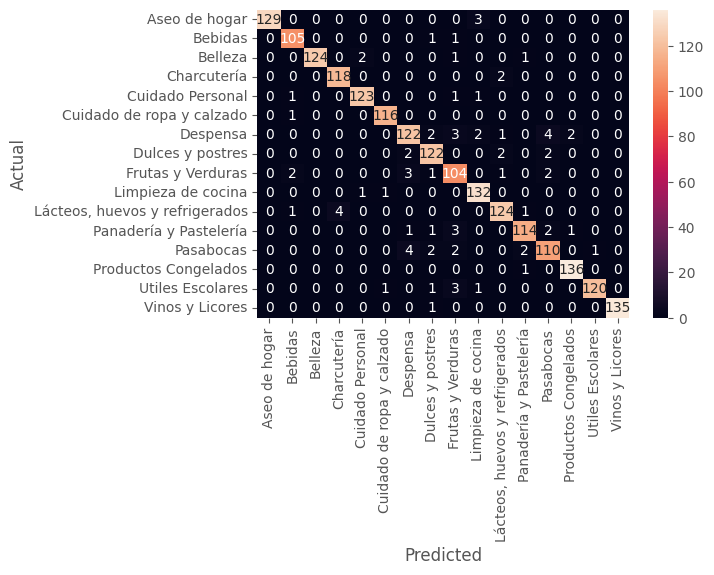

                                precision    recall  f1-score   support

                 Aseo de hogar       1.00      0.98      0.99       132
                       Bebidas       0.95      0.98      0.97       107
                       Belleza       1.00      0.97      0.98       128
                   Charcutería       0.97      0.98      0.98       120
              Cuidado Personal       0.98      0.98      0.98       126
     Cuidado de ropa y calzado       0.98      0.99      0.99       117
                      Despensa       0.92      0.90      0.91       136
              Dulces y postres       0.93      0.95      0.94       128
             Frutas y Verduras       0.88      0.92      0.90       113
            Limpieza de cocina       0.95      0.99      0.97       134
Lácteos, huevos y refrigerados       0.95      0.95      0.95       130
        Panadería y Pastelería       0.96      0.93      0.95       122
                     Pasabocas       0.92      0.91      0.91  

In [70]:
#Matriz de confusión LinearSVC

y_pred = modeltext71.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['subcategory'].sort_values().unique()
            , yticklabels=df['subcategory'].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred))

A nivel general el modelo seleccionado obtuvo un F1-Score alto sin incurrir en sobreajuste

In [71]:
#Se guarda modelo en Drive para su posterior uso
import os
if not os.path.exists('/content/drive/My Drive/modelos'):
    os.makedirs('/content/drive/My Drive/modelos')


joblib.dump(modeltext71, '/content/drive/My Drive/modelos/model71TiendasTextSVC.pkl')

['/content/drive/My Drive/modelos/model71TiendasTextSVC.pkl']

### 9. Producción

Ejecución con modelo seleccionado (LinearSVC)

In [72]:
response3 = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/model71TiendasTextSVC.pkl')
response3.raise_for_status()

modeltext71C = joblib.load(BytesIO(response3.content)) # Carga del modelo.


In [73]:
def queryCategory1(query):

    texts = [query]
    text_features = vectorizer.transform(texts)
    p=text_features.nonzero()[0]

    predictionsId = modeltext71C.predict(text_features)

    predictions = predictionsId

    return predictions

In [74]:
queryCategory1("cepillo colgate")

array(['Cuidado Personal'], dtype=object)

In [79]:
productos = [
    "GOLD MAR BLONDER",
    "SEDA JOHNSONS EXPANSION PLUS MENTAX 50 MT",
    "CONO NUCITA",
    "AGUA AANELA",
    "PANELA INSTANTANEA SABOR GENGIBRE LIMON",
    "MANZANA",
    "CUADERNO"]

for producto in productos:
    print(producto, queryCategory1(producto))

GOLD MAR BLONDER ['Productos Congelados']
SEDA JOHNSONS EXPANSION PLUS MENTAX 50 MT ['Cuidado Personal']
CONO NUCITA ['Frutas y Verduras']
AGUA AANELA ['Bebidas']
PANELA INSTANTANEA SABOR GENGIBRE LIMON ['Despensa']
MANZANA ['Frutas y Verduras']
CUADERNO ['Utiles Escolares']


In [80]:
queryCategory1("crema corporal")

array(['Belleza'], dtype=object)

In [81]:
queryCategory1("cepillo de dientes colgate")

array(['Cuidado Personal'], dtype=object)

### **10. Generar Dataset para modelo de Regresion**

Se procede a aplicar el modelo de clasificación seleccionado en el Dataset de Compras, con esto se obtendría la clasificación de productos para proceder con el modelo de Regresión

In [83]:
## Se procede a cargar la base de datos de compras para categorizar los productos

response2 = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/ComprasDda.xlsx')
response2.raise_for_status()  # en caso de que la descargue falle

# leer información del archivo en Dataframe
compras = pd.read_excel(io.BytesIO(response2.content), sheet_name="Compras2022", engine='openpyxl')

In [84]:
len(compras['PRODUCTO'])

16383

In [85]:
#evaluar todos los productos de la lista 'productos' con queryCategory1 - Modelo LinearSVC

compras['CATEGORIA'] = compras['PRODUCTO'].apply(queryCategory1)

compras['CATEGORIA']


,CATEGORIA
0,[Frutas y Verduras]
1,[Frutas y Verduras]
2,[Frutas y Verduras]
3,[Frutas y Verduras]
4,[Frutas y Verduras]
...,...
16378,[Pasabocas]
16379,[Charcutería]
16380,[Frutas y Verduras]
16381,[Frutas y Verduras]


Numero de registros categorizados por el modelo LinearSVC en la base de datos de compras

In [86]:
compras['CATEGORIA'].value_counts()

,count
CATEGORIA,
[Frutas y Verduras],5039
[Pasabocas],2419
[Despensa],1744
[Dulces y postres],1275
[Cuidado Personal],1016
"[Lácteos, huevos y refrigerados]",895
[Limpieza de cocina],654
[Utiles Escolares],640
[Charcutería],633


In [87]:
len(compras['CATEGORIA'])

16383

In [88]:
#guardar la base de datos
compras.to_excel('ComprasCategorizadas_SVC.xlsx', index=False)

## Referencias
- Clasificación automática de textos usando redes
de palabras (https://scielo.conicyt.cl/pdf/signos/v47n86/a01.pdf)
- Base de Datos para entrenamiento (https://www.kaggle.com/datasets/camiloemartinez/productos-consumo-masivo/data)
- Base de datos de compras (https://www.kaggle.com/datasets/davidms8/shopping-map)